In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import MeanAbsolutePercentageError
from datetime import datetime, timedelta
rdseed = 123
def set_all_seeds(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
set_all_seeds(rdseed)

d:\Anaconda3\envs\DLinear\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
d:\Anaconda3\envs\DLinear\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
d:\Anaconda3\envs\DLinear\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
# DLinear模型
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, kernel_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)

        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        
        # Use this two lines if you want to visualize the weights
        # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
 
        seasonal_output = self.Linear_Seasonal(seasonal_init)

        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [3]:
class Dataset_Custom(Dataset):
    def __init__(self, df, seq_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        # input
        input_begin = index
        input_end = input_begin + self.seq_len

        # label
        label_begin = input_end
        label_end = label_begin + self.pred_len

        seq_x = self.df[input_begin:input_end]
        seq_y = self.df[label_begin:label_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

def shift_date_24(start_date, days_to_shift):
    # 将字符串格式日期转换为 datetime 对象
    date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 向后推移指定天数
    shifted_date = date_obj + timedelta(days=days_to_shift)
    
    # 将结果转换为字符串格式并返回
    shifted_date_str = shifted_date.strftime('%Y-%m-%d')
    return shifted_date_str
# 重新初始化模型的权重
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


In [4]:
tickers = ["EEM", "EFA", "JPXN", "SPY", "VTI", "XLK",'VTI','AGG','DBC']

EEM


100%|██████████| 200/200 [00:01<00:00, 194.55it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


EFA


100%|██████████| 200/200 [00:01<00:00, 192.56it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


JPXN


100%|██████████| 200/200 [00:01<00:00, 183.88it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


SPY


100%|██████████| 200/200 [00:01<00:00, 183.82it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


VTI


100%|██████████| 200/200 [00:01<00:00, 183.20it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


XLK


100%|██████████| 200/200 [00:01<00:00, 197.22it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


VTI


100%|██████████| 200/200 [00:01<00:00, 188.23it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


AGG


100%|██████████| 200/200 [00:01<00:00, 191.75it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


DBC


100%|██████████| 200/200 [00:01<00:00, 191.39it/s]
C:\Users\123\AppData\Local\Temp\ipykernel_3496\4175518911.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAL['pred'] = RES.values


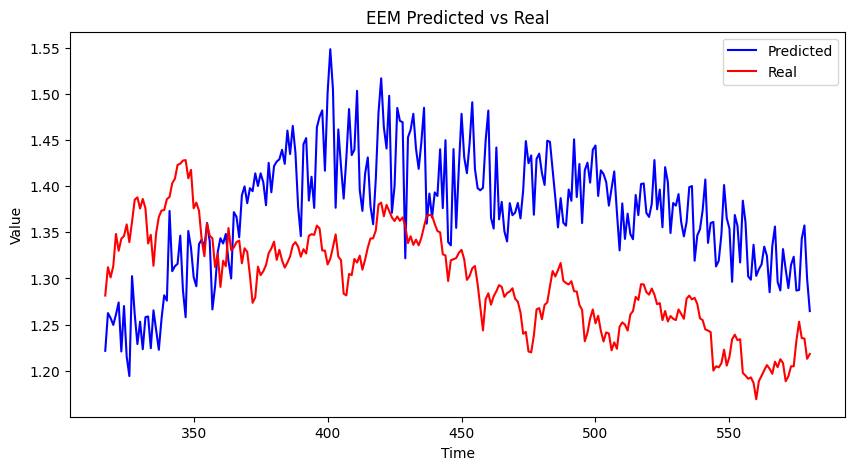

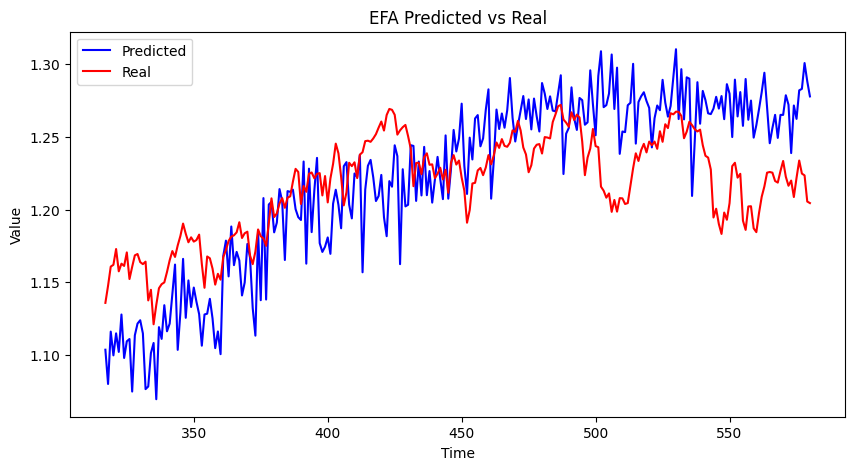

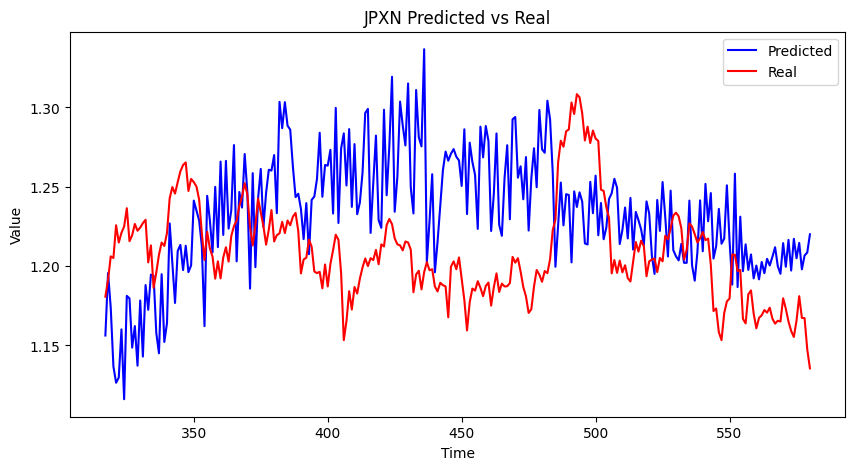

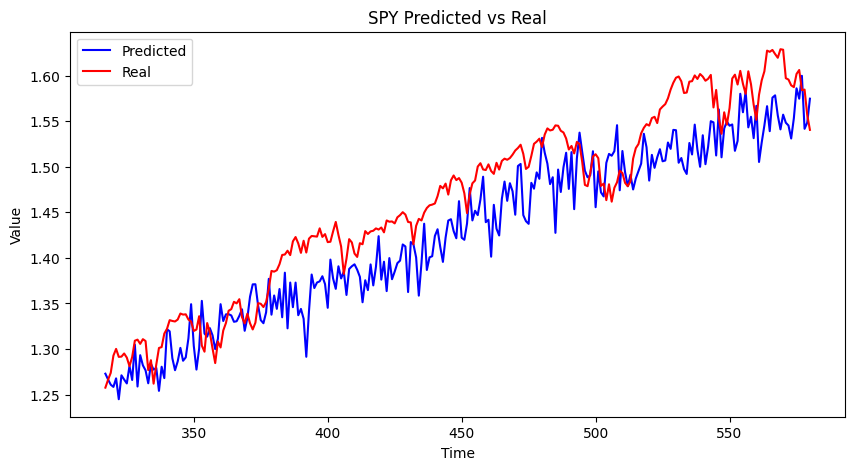

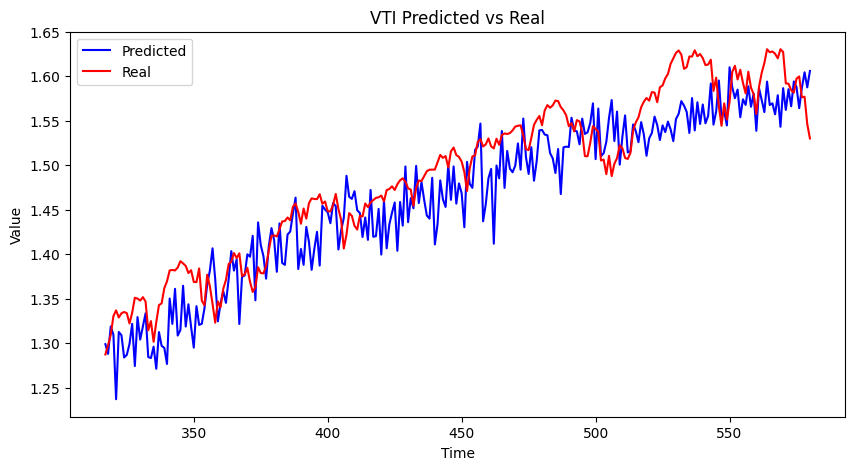

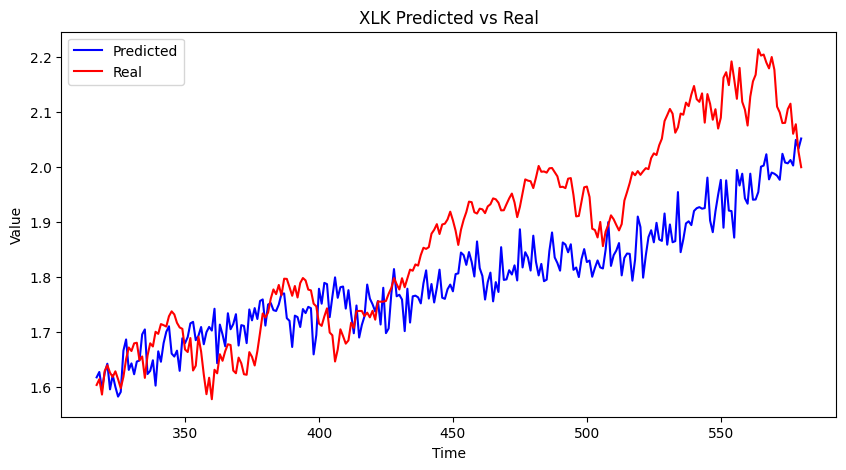

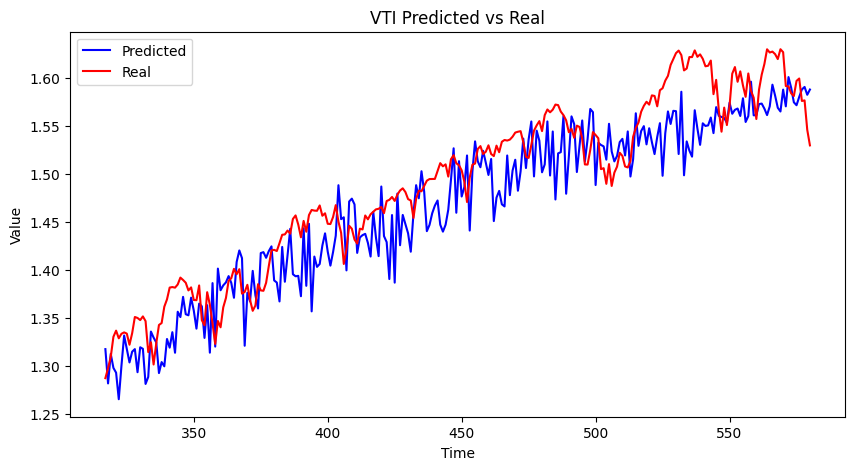

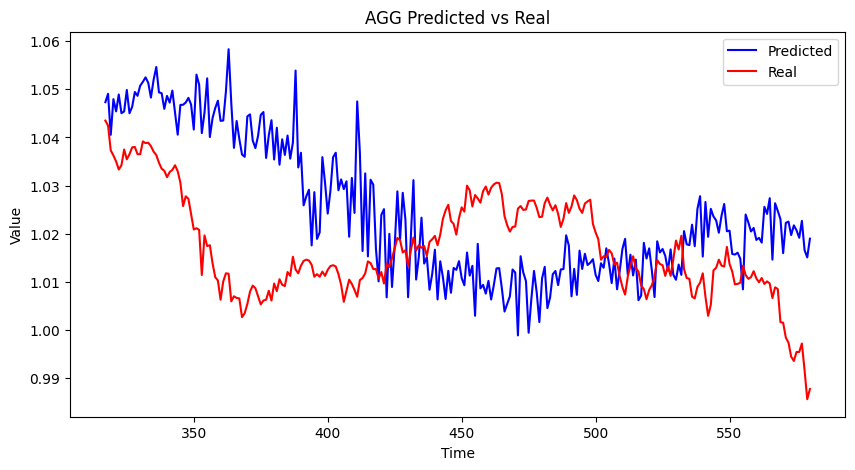

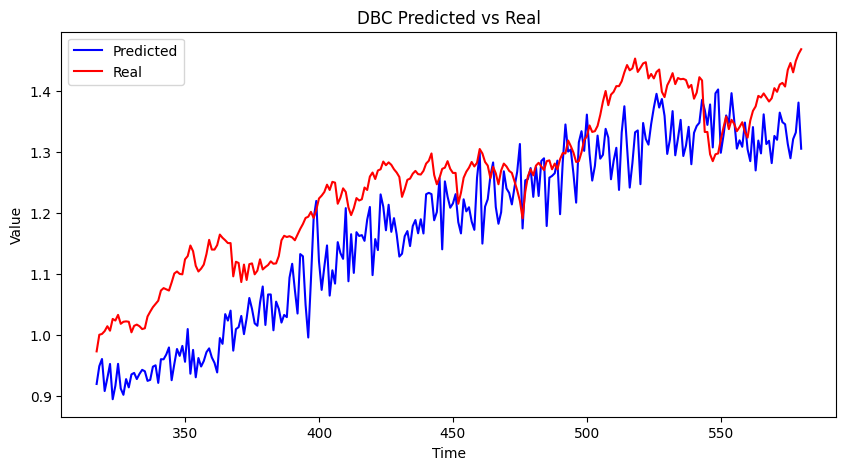

In [5]:
for ticker in tickers: 
    start_date = '2019-10-01'
    end_date = '2021-01-01'
    print(ticker)
    RES = pd.DataFrame()   
    for i in range(11):    
        # history : 2019-10-01 ~ 2022-01-01 的数据
        history = pd.read_csv(f'data\{ticker}.csv')
        history['date'] = pd.to_datetime(history['date'])

        # data : Warming Up 期间的数据
        data = history[(history['date'] >= start_date) 
                    & (history['date'] <= end_date)]
        df = data[["Return"]]
        #df.plot(figsize=(15,5), title="Closing Price of Asset")
        df = df.reset_index(drop=True)
        #df.plot(figsize=(15,5), title = 'Daily percentage change (Daily Return)')
        df_norm = df.to_numpy()
        num_epoch = 200
        config = dict(
            batch_size= 64,
            kernel_size= 21,
            learning_rate= 0.0001,
            seq_len= 48,
            pred_len= 24,
        )
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        data_set = Dataset_Custom(
                df=df_norm,
                seq_len=config['seq_len'],
                pred_len=config['pred_len']
                )

        data_loader = DataLoader(
                data_set,
                batch_size=config['batch_size'],
                shuffle=True,
                drop_last=False)

        model = DLinear(seq_len=config['seq_len'],
                        pred_len=config['pred_len'],
                        kernel_size=config['kernel_size']
                        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.L1Loss().to(device)

        train_loss_ep = []
        for epoch in tqdm(range(num_epoch)):
            train_loss = []

            model.train()
            for i, (batch_x, batch_y) in enumerate(data_loader):
                
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)

                outputs = model(batch_x)


                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                #log
                train_loss.append(loss.item())

            train_loss_ep.append(np.average(train_loss))

            #print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")
        #pd.DataFrame(train_loss_ep).plot()
        r = df_norm[-config['seq_len']:,:]
        x = torch.tensor(r[-config['seq_len']:,:]).unsqueeze(0)
        model.eval()
        with torch.no_grad():
            output = model(x.float().to(device))
        r = np.append(r, output.squeeze(0).to("cpu").detach().numpy(), axis=0)
        res_df = pd.DataFrame(r[-24:])
        res_df.columns = ["ret_pred"]
        #res_df.plot(figsize=(15,5))
        if RES.empty:
            RES = res_df
        else :
            RES = pd.concat([RES,res_df],axis = 0, ignore_index = True)
        start_date = shift_date_24(start_date, 24)
        end_date = shift_date_24(end_date, 24)
        reset_weights(model)
    
    
    REAL = history[(history['date'] >= '2021-01-04') 
                & (history['date'] <= '2022-01-19')]
    REAL['pred'] = RES.values

    # 假设 pred 和 real 是你的两个时间序列数据

    # 创建一个新的图形
    plt.figure(figsize=(10, 5))

    # 绘制 pred 数据
    plt.plot(REAL['pred'], label='Predicted', color='blue')

    # 绘制 real 数据
    plt.plot(REAL['Return'], label='Real', color='red')

    # 添加标题和标签
    plt.title(f'{ticker} Predicted vs Real')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # 添加图例
    plt.legend()

    # 显示图形
    plt.savefig(f'image\{rdseed}_{ticker}png', dpi=300)

    REAL.to_csv(f'res\{rdseed}_{ticker}pred.csv', index =False)